Author: Tianyu Zhang  
Update Time: 10/03/2019 18:43  
Version: v1.1
UID: N19645827  
Email: tianyuzhang@nyu.edu  

Enviornment:  
Windows 10 pro X64  
i7-8750H CPU  
PyTorch Version: 1.2.0  
Numpy Version: 1.16.2  

# Computer Vision CSCI-GA.2272-001 Assignment 1

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch, modify this ipython notebook

To install PyTorch, follow instructions at http://pytorch.org/

Please submit your assignment by uploading this iPython notebook to NYU classes.

## Warmup [10%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

## Training a Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.
-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

- Give a breakdown of the parameters within the above model, and the overall number.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
# options
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

## Warmup: visualization

In [5]:
import matplotlib.pyplot as plt
import numpy as np
# Data Loading
# Get MNIST
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

#--------------CPU------------------
m_trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
m_testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

m_train_loader = torch.utils.data.DataLoader(m_trainset, batch_size=batch_size, shuffle=True, num_workers=0)
m_test_loader  = torch.utils.data.DataLoader(m_testset, batch_size=batch_size, shuffle=False, num_workers=0)
m_classes = (0,1,2,3,4,5,6,7,8,9)

In [6]:
# Get CIFAR10
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#--------------CPU------------------
c_trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)   
c_testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

c_train_loader = torch.utils.data.DataLoader(c_trainset, batch_size=batch_size, shuffle=True, num_workers=0)
c_test_loader  = torch.utils.data.DataLoader(c_testset, batch_size=batch_size, shuffle=False, num_workers=0)
c_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: 
    5    5    7    5    2    4    3    9


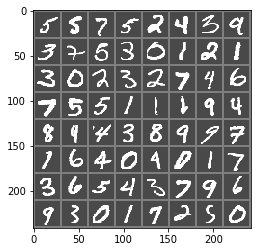

In [7]:
import torchvision 
# reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images from MNIST
dataiter = iter(m_train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels: ')
print(''.join('%5s' % m_classes[labels[j]] for j in range(8)))

torch.Size([64, 3, 32, 32])
Labels: 
 deer plane  ship  bird  bird   cat  ship  bird


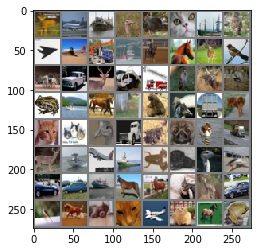

In [45]:
# get some random training images from CIFAR-10
dataiter = iter(c_train_loader)
images, labels = dataiter.next()
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels: ')
print(' '.join('%5s' % c_classes[labels[j]] for j in range(8)))

## Training a Single Layer Network on MNIST

In [9]:
## network and optimizer
def get_num_inputs(data_name):
    if data_name == 'mnist':
        num_inputs = 784
    elif data_name == 'cifar10':
        num_inputs = 3072
    return num_inputs

In [10]:
num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
num_inputs = get_num_inputs('mnist')
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [14]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(m_train_loader):
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(m_train_loader.dataset),
                100. * batch_idx / len(m_train_loader), loss.item()))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in m_test_loader:
        data, target = Variable(data, volatile=True), Variable(target)

        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(m_test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(m_test_loader.dataset),
        100. * correct / len(m_test_loader.dataset)))

In [15]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.550323
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.691030
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.547867
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.410309
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.612060
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.306795
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.577223
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.529478
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.278530
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.251242


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.3320, Accuracy: 9085/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.310130
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.312942
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.278076
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.327879
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.317746
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.298671
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.423213
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.377947
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.294774
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.307148

Test set: Average loss: 0.3053, Accuracy: 9131/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.275998
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.294319
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.340224
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.253646
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.148759
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.200765
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.294850
Train Epoch: 3 [44800/60000 (75%)]	Loss:

(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: #1 #2 )

Ans:

In [16]:
print(network.state_dict().keys())

odict_keys(['linear.weight', 'linear.bias'])


In [17]:
network_W = network.state_dict()['linear.weight']
print(network_W.shape)

torch.Size([10, 784])


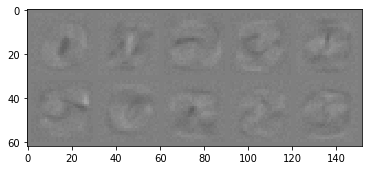

In [18]:
network_W_reshape = network_W.reshape(10,1,28,28)
def imshow_weight(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow_weight(torchvision.utils.make_grid(network_W_reshape,nrow = 5).cpu())

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the train function]. Paste the output into your report and explain what is happening to the model.

In [20]:
network_example_50 = Net(num_inputs, num_outputs)
optimizer_example_50 = optim.SGD(network_example_50.parameters(), lr=lr)

def train_example_50(epoch):
    network_example_50.train()
    for batch_idx, (data, target) in enumerate(m_train_loader):
        data, target = Variable(data[:50]), Variable(target[:50])
        optimizer_example_50.zero_grad()
        output = network_example_50(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer_example_50.step()
        # only one batch in the training set because we reduce 
        # the number of training examples to just 50.
        if batch_idx == 0:
            break

def test_example_50():
    network_example_50.eval()
    test_loss = 0
    correct = 0
    for data, target in m_test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network_example_50(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(m_test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(m_test_loader.dataset),
        100. * correct / len(m_test_loader.dataset)))
    
for epoch in range(1, epochs + 1):
    train_example_50(epoch)
    test_example_50()

c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Average loss: 2.4048, Accuracy: 1439/10000 (14%)


Test set: Average loss: 2.2598, Accuracy: 1728/10000 (17%)


Test set: Average loss: 2.1285, Accuracy: 2537/10000 (25%)


Test set: Average loss: 2.0405, Accuracy: 3004/10000 (30%)


Test set: Average loss: 1.9427, Accuracy: 3689/10000 (36%)


Test set: Average loss: 1.8562, Accuracy: 4410/10000 (44%)


Test set: Average loss: 1.7840, Accuracy: 4771/10000 (47%)


Test set: Average loss: 1.7223, Accuracy: 4984/10000 (49%)


Test set: Average loss: 1.6752, Accuracy: 5090/10000 (50%)


Test set: Average loss: 1.6188, Accuracy: 5236/10000 (52%)



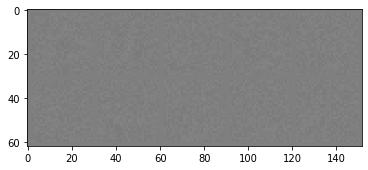

In [21]:
network_example_50_W = network_example_50.state_dict()['linear.weight']
network_example_50_W_reshape = network_example_50_W.reshape(10,1,28,28)
def imshow_weight(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow_weight(torchvision.utils.make_grid(network_example_50_W_reshape,nrow = 5).cpu())

Explain what is happening to the model:  
The training dataset is too small which is not enough to learn the right weight which means the variance of the estimation is too large. Also, it is very likely to overfitting because there is only a small amount of data but the the number of parameters for the neural network model is to large. Thus, from what we have seen here, the weight under this situation is just like noises.

## Training a Multi-Layer Network on MNIST

Add an extra layer to the network with 1000 hidden units and a tanh non-linearity. [Hint: modify the Net class]. Train the model for 10 epochs and save the output into your report.

In [22]:
num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
num_inputs = get_num_inputs('mnist')
num_hiddens = 1000
class Multi_Layer_Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Multi_Layer_Net, self).__init__()
        self.linear1 = nn.Linear(num_inputs, num_hiddens)
        self.linear2 = nn.Linear(num_hiddens, num_outputs)
        
    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear1(input)
        output = nn.functional.tanh(output)
        output = self.linear2(output)
        return output

multi_network = Multi_Layer_Net(num_inputs, num_outputs)
multi_optimizer = optim.SGD(multi_network.parameters(), lr=lr)

In [24]:
def train_multi(epoch):
    multi_network.train()
    for batch_idx, (data, target) in enumerate(m_train_loader):
        data, target = Variable(data), Variable(target)
        multi_optimizer.zero_grad()
        output = multi_network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        multi_optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(m_train_loader.dataset),
                100. * batch_idx / len(m_train_loader), loss.item()))

def test_multi():
    multi_network.eval()
    test_loss = 0
    correct = 0
    for data, target in m_test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = multi_network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(m_test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(m_test_loader.dataset),
        100. * correct / len(m_test_loader.dataset)))

In [25]:
for epoch in range(1, epochs + 1):
    train_multi(epoch)
    test_multi()

c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298218
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.753551
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.474658
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.441762
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.295922
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.545521
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.638211
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.460670
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.218034
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.306678


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Average loss: 0.3264, Accuracy: 9076/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.215242
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.283330
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.305874
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.309168
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.344824
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.276452
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.226815
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.394519
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.394016
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.335827

Test set: Average loss: 0.2838, Accuracy: 9206/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.245311
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.189624
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.218164
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.160527
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.319589
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.239083
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.308424
Train Epoch: 3 [44800/60000 (75%)]	Loss:

Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

In [26]:
multi_network_lr_10 = Multi_Layer_Net(num_inputs, num_outputs)
multi_optimizer_lr_10 = optim.SGD(multi_network_lr_10.parameters(), lr=10)

def train_multi_lr_10(epoch):
    multi_network_lr_10.train()
    for batch_idx, (data, target) in enumerate(m_train_loader):
        data, target = Variable(data), Variable(target)
        multi_optimizer_lr_10.zero_grad()
        output = multi_network_lr_10(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        multi_optimizer_lr_10.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(m_train_loader.dataset),
                100. * batch_idx / len(m_train_loader), loss.item()))

def test_multi_lr_10():
    multi_network_lr_10.eval()
    test_loss = 0
    correct = 0
    for data, target in m_test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = multi_network_lr_10(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(m_test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(m_test_loader.dataset),
        100. * correct / len(m_test_loader.dataset)))
    
for epoch in range(1, 10 + 1):
    train_multi_lr_10(epoch)
    test_multi_lr_10()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300433
Train Epoch: 1 [6400/60000 (11%)]	Loss: 521.890442
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1012.640442
Train Epoch: 1 [19200/60000 (32%)]	Loss: 400.017426
Train Epoch: 1 [25600/60000 (43%)]	Loss: 201.714005
Train Epoch: 1 [32000/60000 (53%)]	Loss: 254.476761
Train Epoch: 1 [38400/60000 (64%)]	Loss: 323.409943
Train Epoch: 1 [44800/60000 (75%)]	Loss: 609.678101
Train Epoch: 1 [51200/60000 (85%)]	Loss: 246.096405
Train Epoch: 1 [57600/60000 (96%)]	Loss: 265.532928


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Average loss: 291.9237, Accuracy: 6187/10000 (61%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 290.950287
Train Epoch: 2 [6400/60000 (11%)]	Loss: 402.856262
Train Epoch: 2 [12800/60000 (21%)]	Loss: 541.680054
Train Epoch: 2 [19200/60000 (32%)]	Loss: 593.331299
Train Epoch: 2 [25600/60000 (43%)]	Loss: 171.573486
Train Epoch: 2 [32000/60000 (53%)]	Loss: 117.823074
Train Epoch: 2 [38400/60000 (64%)]	Loss: 228.585068
Train Epoch: 2 [44800/60000 (75%)]	Loss: 136.551437
Train Epoch: 2 [51200/60000 (85%)]	Loss: 143.974457
Train Epoch: 2 [57600/60000 (96%)]	Loss: 516.585938

Test set: Average loss: 312.7925, Accuracy: 5910/10000 (59%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 203.432602
Train Epoch: 3 [6400/60000 (11%)]	Loss: 344.013367
Train Epoch: 3 [12800/60000 (21%)]	Loss: 158.946167
Train Epoch: 3 [19200/60000 (32%)]	Loss: 263.884430
Train Epoch: 3 [25600/60000 (43%)]	Loss: 147.134247
Train Epoch: 3 [32000/60000 (53%)]	Loss: 168.160172
Train Epoch: 3 [38400/60000 (64%)]	Loss: 758.593323
Tr

Give a brief explanation:  
The learning rate is too high which directly leads to big jump on the gradients. The process of gradient decent will zigzag a lot and flucutate around the target. (please see the following graph) which leads to a low accuracy and the situation of hard to converge.

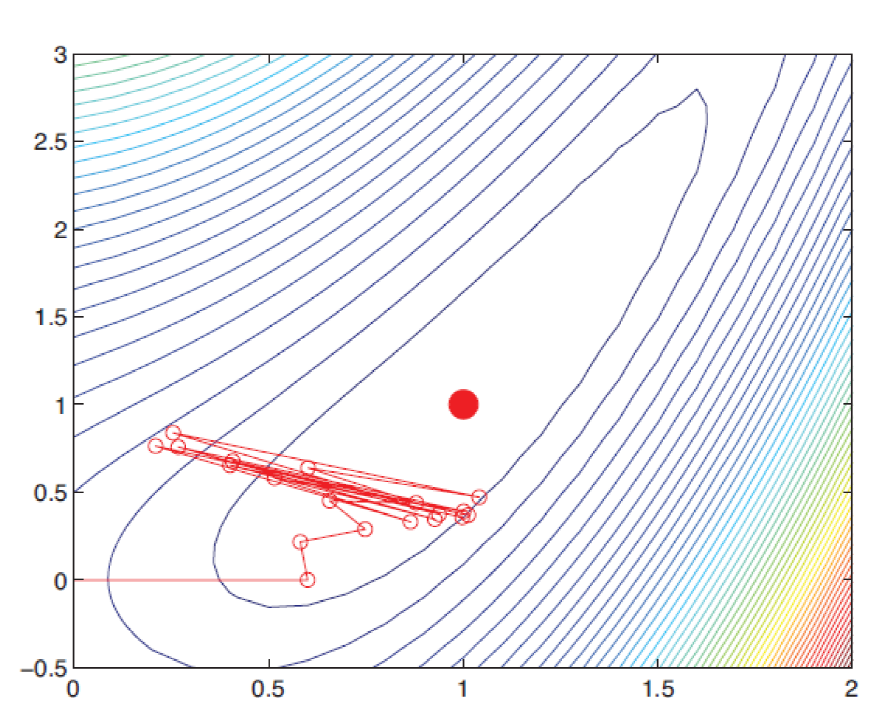

In [42]:
from IPython.display import Image
Image(filename='assignment1_graph.png') 

## Training a Convolutional Network on CIFAR

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

In [46]:
batch_size = 64   # input batch size for training
epochs = 20       # number of epochs to train
lr = 0.01        # learning rate

In [50]:
num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
num_inputs = get_num_inputs('cifar10')
class Conv_Net(nn.Module):
    def __init__(self):
        super(Conv_Net, self).__init__()
        # 3 input image channel, 16 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 16, 5, padding = 0)
        self.conv2 = nn.Conv2d(16, 128, 5, padding = 0)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(128 * 5 * 5, 64)  # 6*6 from image dimension
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.tanh(self.conv1(x)), (2, 2), stride=2)
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.tanh(self.conv2(x)), (2, 2), stride=2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Conv_network = Conv_Net()
Conv_optimizer = optim.SGD(Conv_network.parameters(), lr=0.01, weight_decay=0)

In [51]:
def train_Conv(epoch):
    Conv_network.train()
    for batch_idx, (data, target) in enumerate(c_train_loader):
        data, target = Variable(data), Variable(target)
        Conv_optimizer.zero_grad()
        output = Conv_network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        Conv_optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(c_train_loader.dataset),
                100. * batch_idx / len(c_train_loader), loss.item()))

def test_Conv():
    Conv_network.eval()
    test_loss = 0
    correct = 0
    for data, target in c_test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = Conv_network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(c_test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(c_test_loader.dataset),
        100. * correct / len(c_test_loader.dataset)))

In [52]:
for epoch in range(1, epochs + 1):
    train_Conv(epoch)
    test_Conv()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.290393
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.153432
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.069511
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.876519
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.072128
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.792884
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.760154
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.766971


c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Average loss: 1.7739, Accuracy: 3801/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.780678
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.694336
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.724764
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.704623
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.644739
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.566382
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.547658
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.493629

Test set: Average loss: 1.5935, Accuracy: 4369/10000 (43%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.599870
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.585067
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.480622
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.184711
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.589576
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.442127
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.459059
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.481694

Test set: Average loss: 1.4642, Accuracy: 4759/10000 (47%)

Train Epoch: 4 [0/50000 (0%)]

Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.774033
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.907834

Test set: Average loss: 0.9640, Accuracy: 6672/10000 (66%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.629724
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.742572
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.895721
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.933336
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.790442
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.621931
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.831735
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.798087

Test set: Average loss: 0.9321, Accuracy: 6761/10000 (67%)



#### Showing the image of the first layer filters

In [31]:
filter_1st_layer = Conv_network.conv1.weight.data

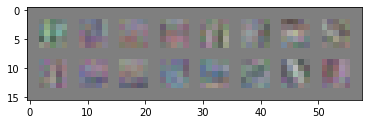

In [34]:
def imshow_weight(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow_weight(torchvision.utils.make_grid(filter_1st_layer).cpu())

#### Print the summary of the parameters: Give a breakdown of the parameters within the above model, and the overall number.

In [41]:
from torchsummary import summary
summary(Conv_network.cpu(), input_size=(3, 32, 32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           1,216
            Conv2d-2          [-1, 128, 16, 16]          51,328
            Linear-3                   [-1, 64]         524,352
            Linear-4                   [-1, 10]             650
Total params: 577,546
Trainable params: 577,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.35
Params size (MB): 2.20
Estimated Total Size (MB): 2.56
----------------------------------------------------------------
